In [1]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
import datetime

import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split

import xgboost
from xgboost import XGBRegressor, DMatrix

In [2]:
#python package version information
print('Python version:{}'.format(sys.version))
print('Numpy version:{}'.format(np.__version__))
print('Pandas version:{}'.format(pd.__version__))
print('MatlpotLib version:{}'.format(matplotlib.__version__))
print('Seaborn version:{}'.format(sns.__version__))
print('Sci-Kit Learn version:{}'.format(sklearn.__version__))
print('XGBoost version:{}'.format(xgboost.__version__))

Python version:3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Numpy version:1.23.3
Pandas version:1.4.4
MatlpotLib version:3.5.2
Seaborn version:0.12.1
Sci-Kit Learn version:1.1.3
XGBoost version:1.7.1


In [3]:
cour = pd.read_csv('eurchf.csv', index_col=0, parse_dates=True, skipinitialspace=True)
cour = cour.drop('volume', axis=1)
cour.describe()

,open,high,low,close
count,5162.000000,5162.000000,5162.000000,5162.000000
mean,1.293008,1.296083,1.289918,1.292968
std,0.212936,0.213367,0.212542,0.212921
min,0.948980,0.952470,0.864300,0.948980
25%,1.093700,1.095912,1.091423,1.093770
50%,1.217220,1.218930,1.215650,1.217250
75%,1.535250,1.539075,1.531550,1.534975
max,1.679100,1.682500,1.675200,1.679500


In [4]:
start_train = datetime.datetime(2010, 1, 1, 0, 0)
cour = cour.loc[start_train:]
cour

,open,high,low,close
Date,,,,
2010-01-01,1.48340,1.48450,1.47920,1.48450
2010-01-04,1.48350,1.48880,1.48080,1.48440
2010-01-05,1.48450,1.48740,1.48240,1.48460
2010-01-06,1.48470,1.48560,1.47890,1.48000
2010-01-07,1.47980,1.48380,1.47660,1.47970
...,...,...,...,...
2022-12-08,0.98848,0.98988,0.98627,0.98848
2022-12-09,0.98793,0.98882,0.98240,0.98793
2022-12-12,0.98373,0.98716,0.98376,0.98373


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


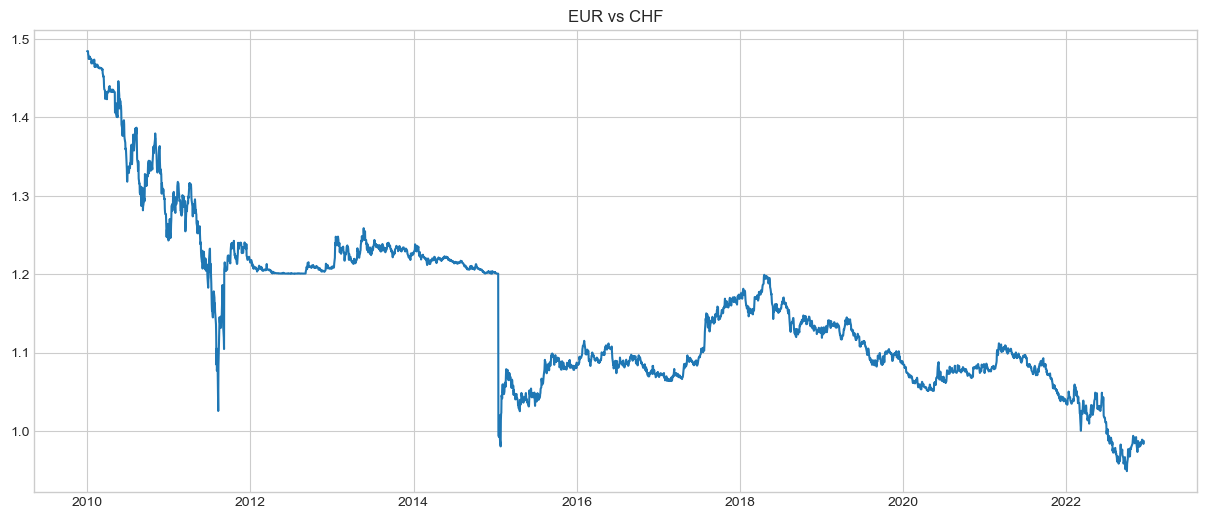

In [5]:
plt.figure(figsize=(15,6))
plt.plot(cour.close)
plt.title('EUR vs CHF')
plt.legend()
plt.show()

In [6]:
def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low", "volume")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    # df_new['open'] = df['open']
    df_new['open_1'] = df['open'].shift(1)
    df_new['close_1'] = df['close'].shift(1)
    df_new['high_1'] = df['high'].shift(1)
    df_new['low_1'] = df['low'].shift(1)
    
    # 50 original features
    # average price
    df_new['avg_price_5'] = df['close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_30'] = df['close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_90'] = df['close'].rolling(window=63).mean().shift(1)
    df_new['avg_price_365'] = df['close'].rolling(window=252).mean().shift(1)
    
    # average price ratio
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_905_'] = df_new['avg_price_5'] / df_new['avg_price_90']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_90'] = df_new['avg_price_30'] / df_new['avg_price_90']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    df_new['ratio_avg_price_90_365'] = df_new['avg_price_90'] / df_new['avg_price_365']                                            
    
    
    # standard deviation of prices
    df_new['std_price_5'] = df['close'].rolling(window=5).std().shift(1)
    df_new['std_price_30'] = df['close'].rolling(window=21).std().shift(1)
    df_new['std_price_90'] = df['close'].rolling(window=63).std().shift(1)                                               
    df_new['std_price_365'] = df['close'].rolling(window=252).std().shift(1)
    
    # standard deviation ratio of prices 
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_90'] = df_new['std_price_5'] / df_new['std_price_90']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_90'] = df_new['std_price_30'] / df_new['std_price_90'] 
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']                                               
    df_new['ratio_std_price_90_365'] = df_new['std_price_90'] / df_new['std_price_365']                                                
    
                                       
    # return
    df_new['return_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['close'] - df['close'].shift(21)) / df['close'].shift(21)).shift(1)
    df_new['return_90'] = ((df['close'] - df['close'].shift(63)) / df['close'].shift(63)).shift(1)                                                
    df_new['return_365'] = ((df['close'] - df['close'].shift(252)) / df['close'].shift(252)).shift(1)
    
    #average of return
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=21).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=63).mean()
    df_new['moving_avg_365'] = df_new['return_1'].rolling(window=252).mean()
    
    # the target
    df_new['close'] = df['close']
    df_new = df_new.dropna(axis=0)
    return df_new


data = generate_features(cour)

In [7]:
data.tail()

,open_1,close_1,high_1,low_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,ratio_avg_price_905_,...,ratio_std_price_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-08,0.98599,0.98599,0.98952,0.98380,0.986394,0.983101,0.976269,1.007321,1.003350,1.010371,...,0.398847,-0.003164,0.000609,-0.004855,0.017114,-0.050124,0.000124,0.000279,-0.000194,0.98848
2022-12-09,0.98848,0.98848,0.98988,0.98627,0.987346,0.982914,0.976615,1.007119,1.004509,1.010988,...,0.400541,0.002525,0.004839,-0.003960,0.022562,-0.049036,0.000968,0.000364,-0.000189,0.98793
2022-12-12,0.98793,0.98793,0.98882,0.98240,0.987766,0.983031,0.976976,1.006905,1.004816,1.011044,...,0.401039,-0.000556,0.002130,0.002506,0.023581,-0.051745,0.000428,0.000380,-0.000200,0.98373
2022-12-13,0.98373,0.98373,0.98716,0.98376,0.987050,0.983045,0.977375,1.006676,1.004074,1.009899,...,0.394862,-0.004251,-0.003626,0.000285,0.026215,-0.055359,-0.000723,0.000420,-0.000215,0.98640
2022-12-14,0.98639,0.98640,0.98990,0.98330,0.986506,0.983589,0.977788,1.006462,1.002966,1.008916,...,0.390533,0.002714,-0.002750,0.011723,0.027104,-0.051903,-0.000547,0.000434,-0.000201,0.98720


In [8]:
data.describe()

,open_1,close_1,high_1,low_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,ratio_avg_price_905_,...,ratio_std_price_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,...,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000
mean,1.132281,1.132268,1.134914,1.129650,1.132455,1.133268,1.135675,1.146824,0.999298,0.997260,...,0.506928,-0.000068,-0.000356,-0.001706,-0.005713,-0.023663,-0.000070,-0.000085,-0.000088,1.132179
std,0.076041,0.076041,0.076003,0.076302,0.075852,0.075456,0.075165,0.076446,0.009287,0.017447,...,0.306412,0.005259,0.011117,0.020622,0.031621,0.058616,0.002217,0.000497,0.000228,0.076048
min,0.948980,0.948980,0.952470,0.864300,0.952990,0.962327,0.968702,1.006462,0.868925,0.845245,...,0.007613,-0.172052,-0.173695,-0.184582,-0.186814,-0.220296,-0.034807,-0.003168,-0.000955,0.948980
25%,1.077500,1.077350,1.079600,1.075000,1.077638,1.077805,1.078850,1.083847,0.996618,0.992475,...,0.296311,-0.001575,-0.003494,-0.007884,-0.014707,-0.059091,-0.000698,-0.000229,-0.000227,1.077300
50%,1.111750,1.111680,1.114080,1.107500,1.111516,1.115516,1.125161,1.128187,0.999523,0.998401,...,0.439290,-0.000075,-0.000328,-0.000827,-0.003688,-0.019152,-0.000065,-0.000054,-0.000072,1.111400
75%,1.206300,1.206230,1.207510,1.205200,1.206726,1.206936,1.207273,1.211452,1.002435,1.004674,...,0.680057,0.001535,0.003008,0.005784,0.007697,0.013684,0.000605,0.000127,0.000058,1.206230
max,1.317900,1.317900,1.323500,1.312600,1.314084,1.305411,1.331926,1.384775,1.042134,1.058923,...,1.807170,0.091880,0.110656,0.184752,0.209126,0.170908,0.021427,0.003137,0.000658,1.317900


<AxesSubplot:xlabel='Date'>

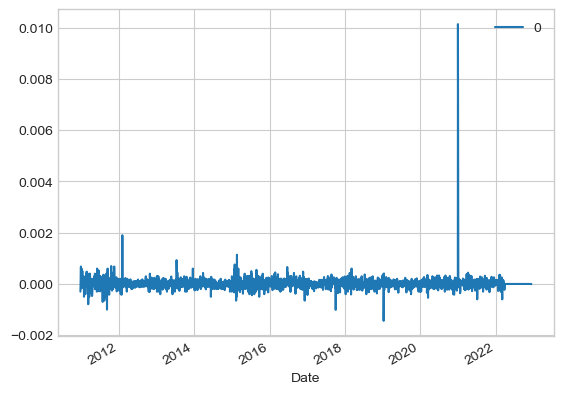

In [9]:
pd.DataFrame(data.open_1 - data.close_1).plot()

<AxesSubplot:>

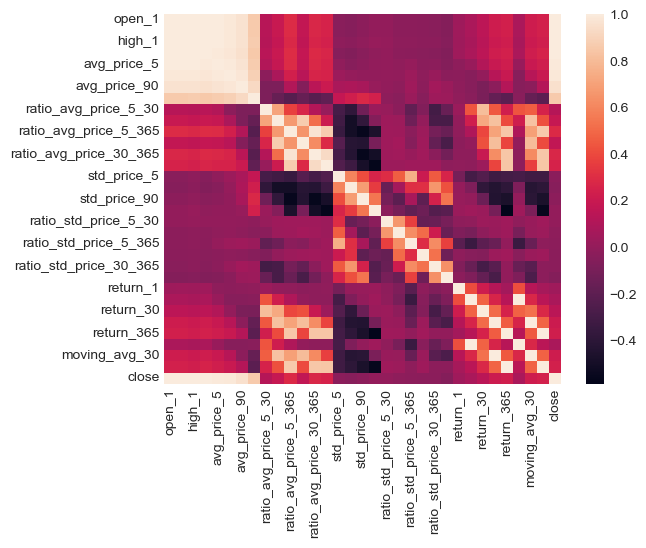

In [10]:
sns.heatmap(data.corr())

### SEGREGATING TRAIN AND TEST DATA

In [11]:
#import datetime module
import datetime

#segregate data for training
end_train = datetime.datetime(2019, 1, 3, 0, 0)
data_train = data.loc[:end_train]
data_test = data.loc[end_train:]
data_train.describe()

,open_1,close_1,high_1,low_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,ratio_avg_price_5_30,ratio_avg_price_905_,...,ratio_std_price_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,...,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000,2092.000000
mean,1.163786,1.163772,1.166556,1.161039,1.163916,1.164581,1.166643,1.176287,0.999470,0.997863,...,0.505697,-0.000041,-0.000222,-0.001208,-0.004142,-0.019386,-0.000042,-0.000057,-0.000067,1.163702
std,0.068444,0.068446,0.068332,0.068876,0.068248,0.067988,0.068506,0.074268,0.010614,0.019737,...,0.341661,0.006035,0.012719,0.023581,0.035833,0.066652,0.002536,0.000560,0.000257,0.068417
min,0.981300,0.980540,0.991500,0.864300,0.998354,1.028701,1.040870,1.062881,0.868925,0.845245,...,0.007613,-0.172052,-0.173695,-0.184582,-0.186814,-0.220296,-0.034807,-0.003168,-0.000955,0.980540
25%,1.092215,1.092315,1.094675,1.089908,1.092021,1.092255,1.094400,1.092514,0.997419,0.994057,...,0.273721,-0.001418,-0.002946,-0.006314,-0.011481,-0.067718,-0.000586,-0.000178,-0.000227,1.092315
50%,1.182200,1.182170,1.188485,1.177190,1.179716,1.183152,1.176887,1.200951,0.999815,0.998675,...,0.421735,0.000000,-0.000167,-0.000187,-0.002357,-0.011626,-0.000033,-0.000034,-0.000039,1.182065
75%,1.218110,1.218110,1.219633,1.216300,1.218084,1.218910,1.219479,1.224371,1.002718,1.005052,...,0.695211,0.001463,0.003094,0.006588,0.009598,0.023841,0.000622,0.000164,0.000098,1.218070
max,1.317900,1.317900,1.323500,1.312600,1.314084,1.305411,1.331926,1.384775,1.042134,1.058923,...,1.807170,0.091880,0.110656,0.184752,0.209126,0.170908,0.021427,0.003137,0.000658,1.317900


In [12]:
X_train = data_train.drop('close', axis='columns')
y_train = data_train.close

X_test = data_test.drop('close', axis='columns')
y_test = data_test.close

#checking the shape of the train and test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2092, 32), (1030, 32), (2092,), (1030,))

### SCALING THE PREDICTOR DATA

In [13]:
#initiating standard scaler
scaler = StandardScaler()

#fit the scaler in training features
scaler.fit(X_train)

#Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [14]:
X_scaled_test.shape

(1030, 32)

In [15]:
def show_evolution(prediction, model_name):
    evolution_df = pd.DataFrame();
    evolution_df["evolution_test_y"] = (y_test - X_test["close_1"].shift()).values
    evolution_df["evolution_prediction"] = (prediction - X_test["close_1"].shift()).values

    evolution_df = evolution_df.dropna().sort_values('evolution_test_y', ascending=False)

    plt.figure(figsize = (18,9))
    plt.style.use('seaborn-whitegrid')
    plot_truth, = plt.plot(evolution_df["evolution_test_y"].values)
    plot_lin, = plt.plot(evolution_df["evolution_prediction"].values)
    plt.legend([plot_truth, plot_lin], ['Truth', 'Linear Regression'])
    plt.title('Price evolution : Prediction vs Truth - '+model_name)
    plt.show()

### LINEAR REGRESSION (LIN)

In [16]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()

lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lin)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lin)))

RMSE: 0.002
MAE: 0.002
R^2: 0.998


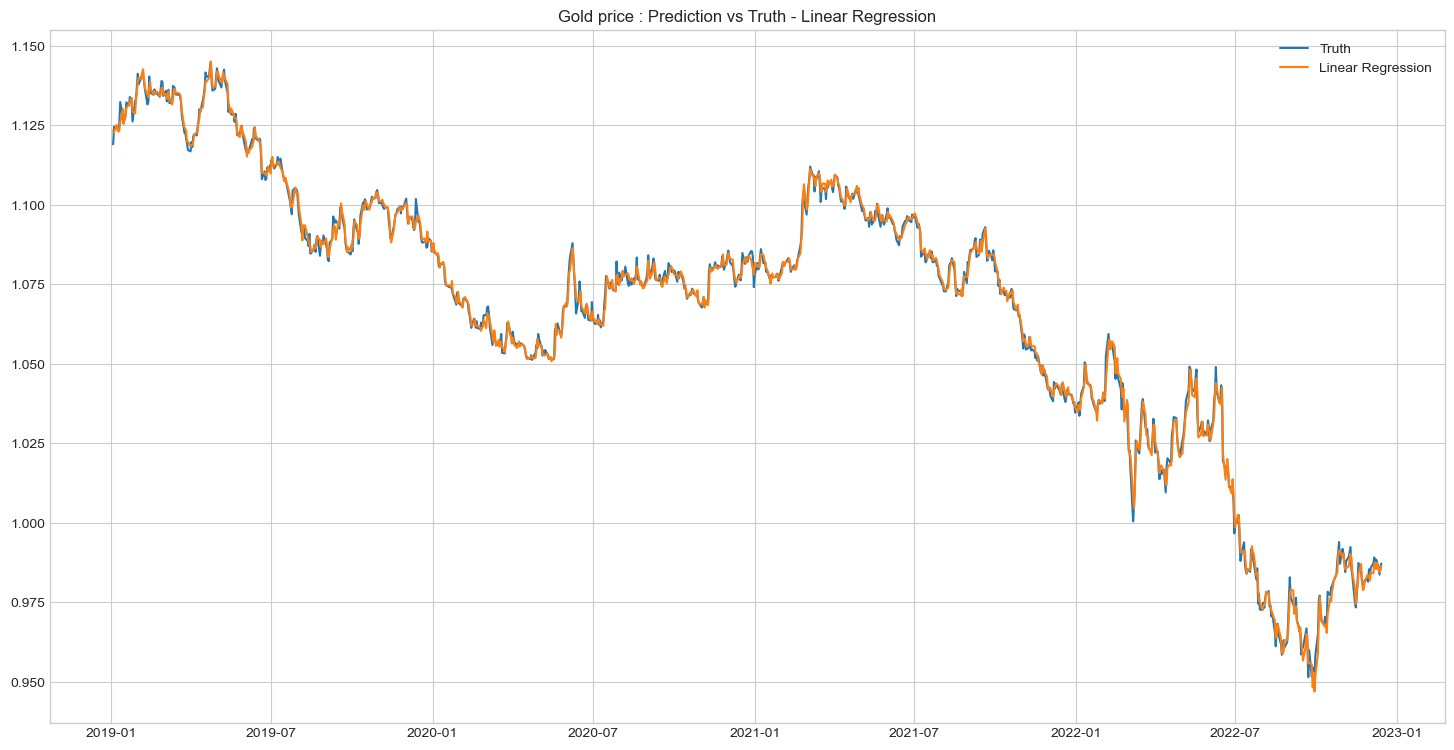

In [17]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plt.style.use('seaborn-whitegrid')
plot_truth, = plt.plot(dates, y_test)
plot_lin, = plt.plot(dates, predictions_lin)
plt.legend([plot_truth, plot_lin], ['Truth', 'Linear Regression'])
plt.title('Gold price : Prediction vs Truth - Linear Regression')
plt.show()

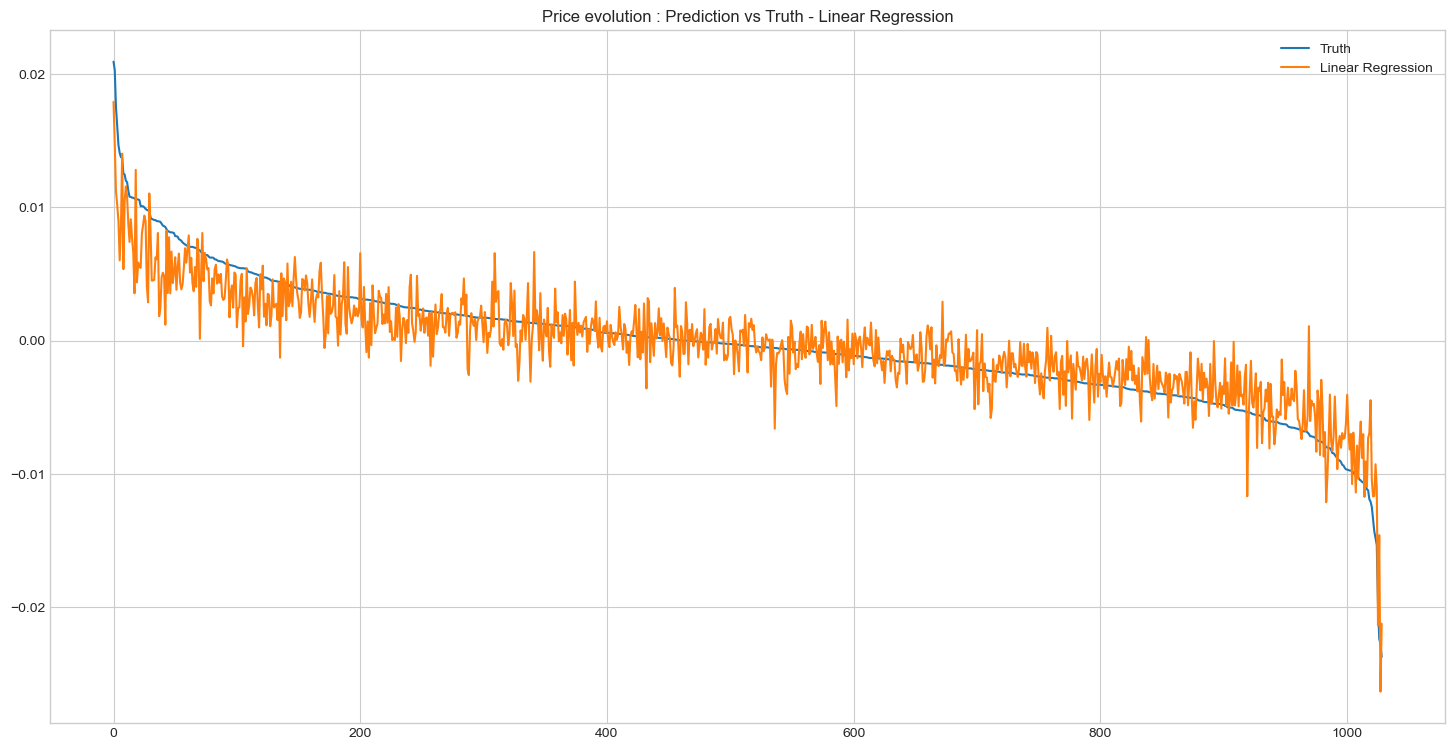

In [18]:
show_evolution(predictions_lin, 'Linear Regression')

In [19]:
df.reset_index(drop=True).plot()

NameError: name 'df' is not defined

### SGD REGRESSOR (SGD)

In [45]:
# First experiment with linear regression

# SGD is very sensitive to data with features at different scales. Hence we need to do feature scaling before training.
#search for the SGD-based linear regression with the optimal set of parameters. 
from sklearn.linear_model import SGDRegressor

param_grid = {
    'penalty':['l1', 'l2', 'elasticnet'],
    "alpha": [1e-5, 3e-5, 1e-4],
    "eta0": [0.01, 0.03, 0.1],
}

sgd = SGDRegressor()
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_scaled_train, y_train)

print(grid_search.best_params_)

sgd_best = grid_search.best_estimator_
#print(grid_search.best_score_)

predictions_sgd = sgd_best.predict(X_scaled_test)

#evaluating the predictions
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_sgd)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_sgd)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_sgd)))

{'alpha': 3e-05, 'eta0': 0.01, 'penalty': 'l1'}
RMSE: 0.003
MAE: 0.002
R^2: 0.995


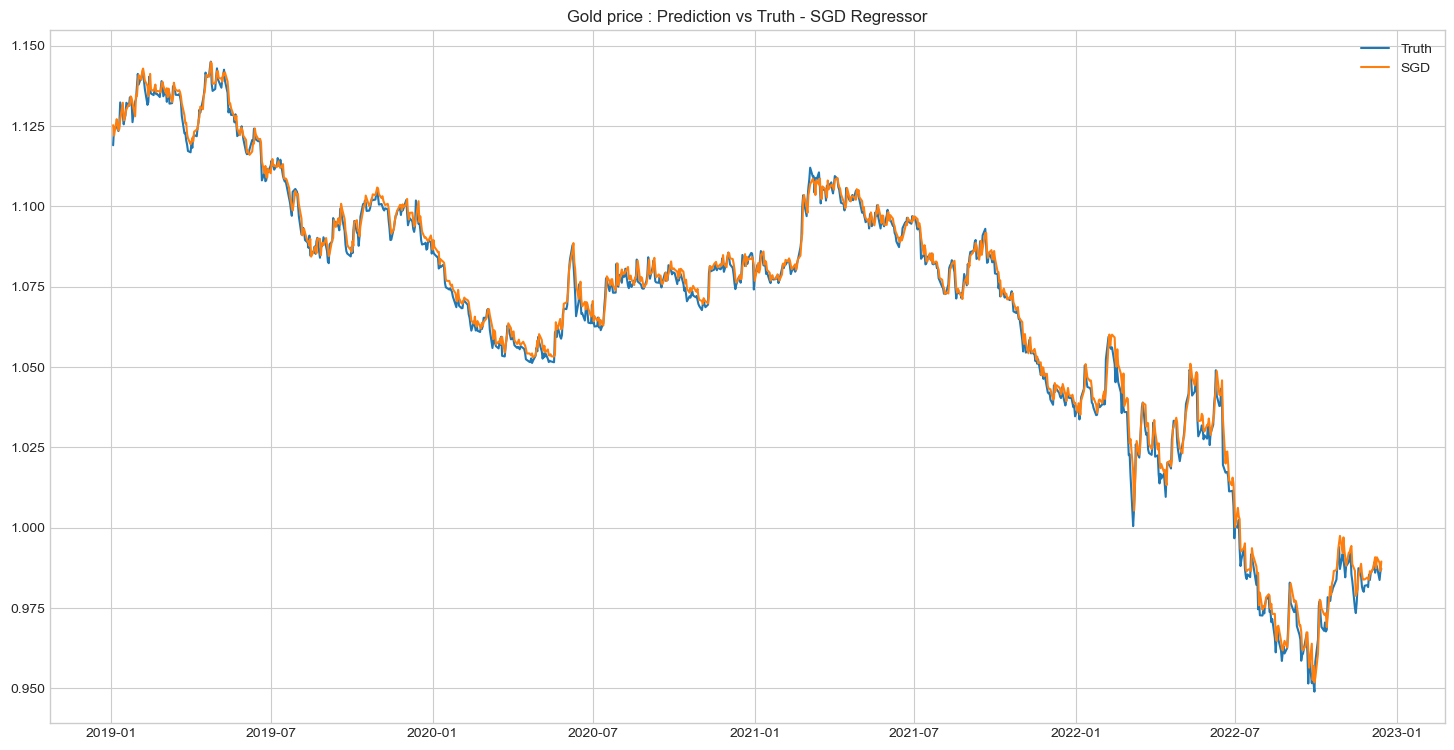

In [46]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_sgd, = plt.plot(dates, predictions_sgd)
plt.legend([plot_truth, plot_sgd], ['Truth', 'SGD'])
plt.title('Gold price : Prediction vs Truth - SGD Regressor')
plt.style.use('seaborn-whitegrid')
plt.show()

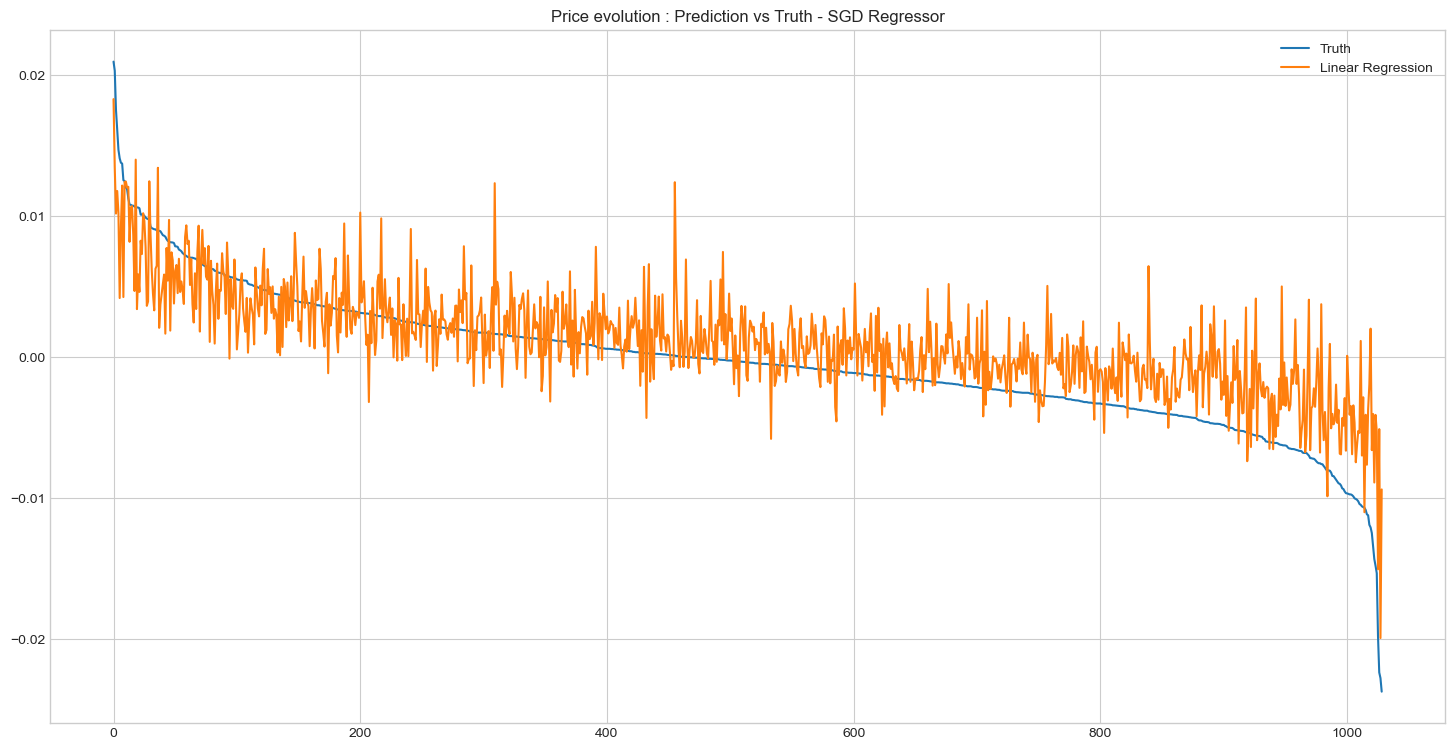

In [47]:
show_evolution(predictions_sgd, 'SGD Regressor')

### Extreme Gradient Boosting Regressor (XGB)

In [48]:
xgb = XGBRegressor()

data_dmatrix = DMatrix(data=X_train,
                           label=y_train)

xgb_param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1],
                  'n_estimators': [50, 100, 200, 300],
                  'subsample': [0.3, 0.5, 0.7, 1]}

grid_search = GridSearchCV(estimator=xgb,    
                        param_grid=xgb_param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                       n_jobs=-1)

grid_search.fit(X_train, y_train) 

print("Best parameters found: ",grid_search.best_params_)

xgb_best = grid_search.best_estimator_

xgb_best.fit(X_train,y_train)
predictions_xgb = xgb_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_xgb)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_xgb)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_xgb)))

Fitting 4 folds for each of 64 candidates, totalling 256 fits
Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.7}
RMSE: 0.008
MAE: 0.004
R^2: 0.970


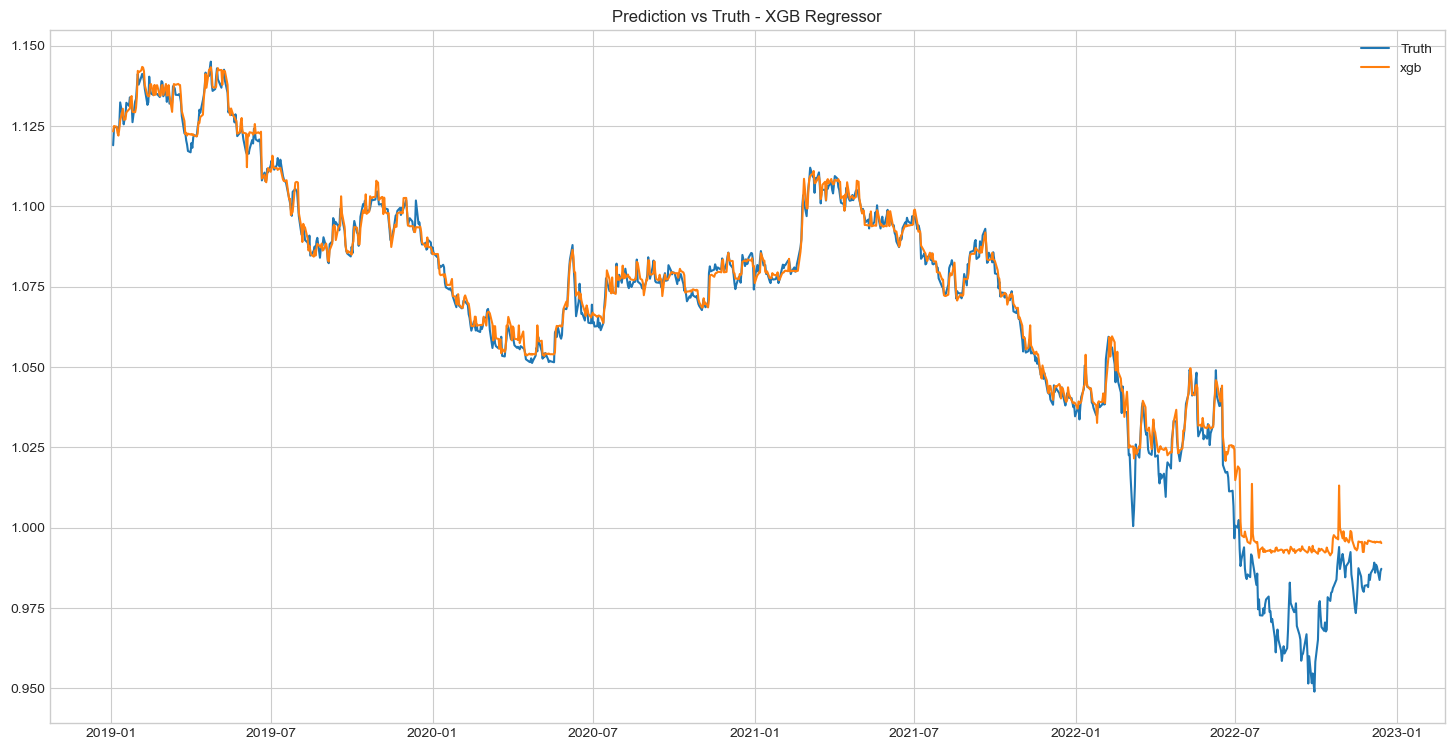

In [49]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_xgb, = plt.plot(dates, predictions_xgb)
plt.legend([plot_truth, plot_xgb], ['Truth', 'xgb'])
plt.title('Prediction vs Truth - XGB Regressor')
plt.show()

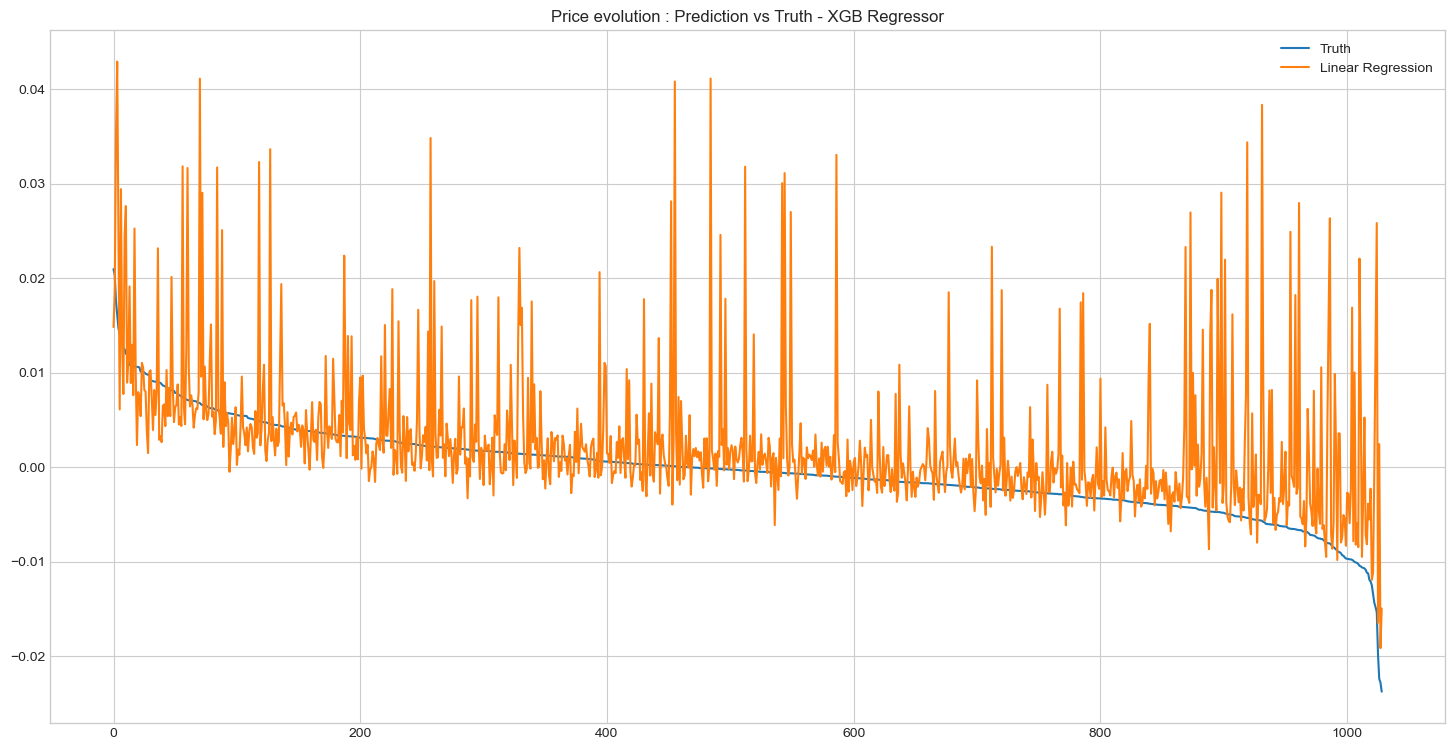

In [50]:
show_evolution(predictions_xgb, 'XGB Regressor')

### Bagging Regressor (BGR)

In [323]:
bgr = BaggingRegressor(base_estimator=lin, n_estimators=100, oob_score=True, n_jobs=-1)

bgr.fit(X_scaled_train, y_train)
predictions_bgr = bgr.predict(X_scaled_test)

print('OOB: {0:.3f}'.format(bgr.oob_score))
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_bgr)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_bgr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_bgr)))

OOB: 1.000
RMSE: 0.002
MAE: 0.001
R^2: 0.998


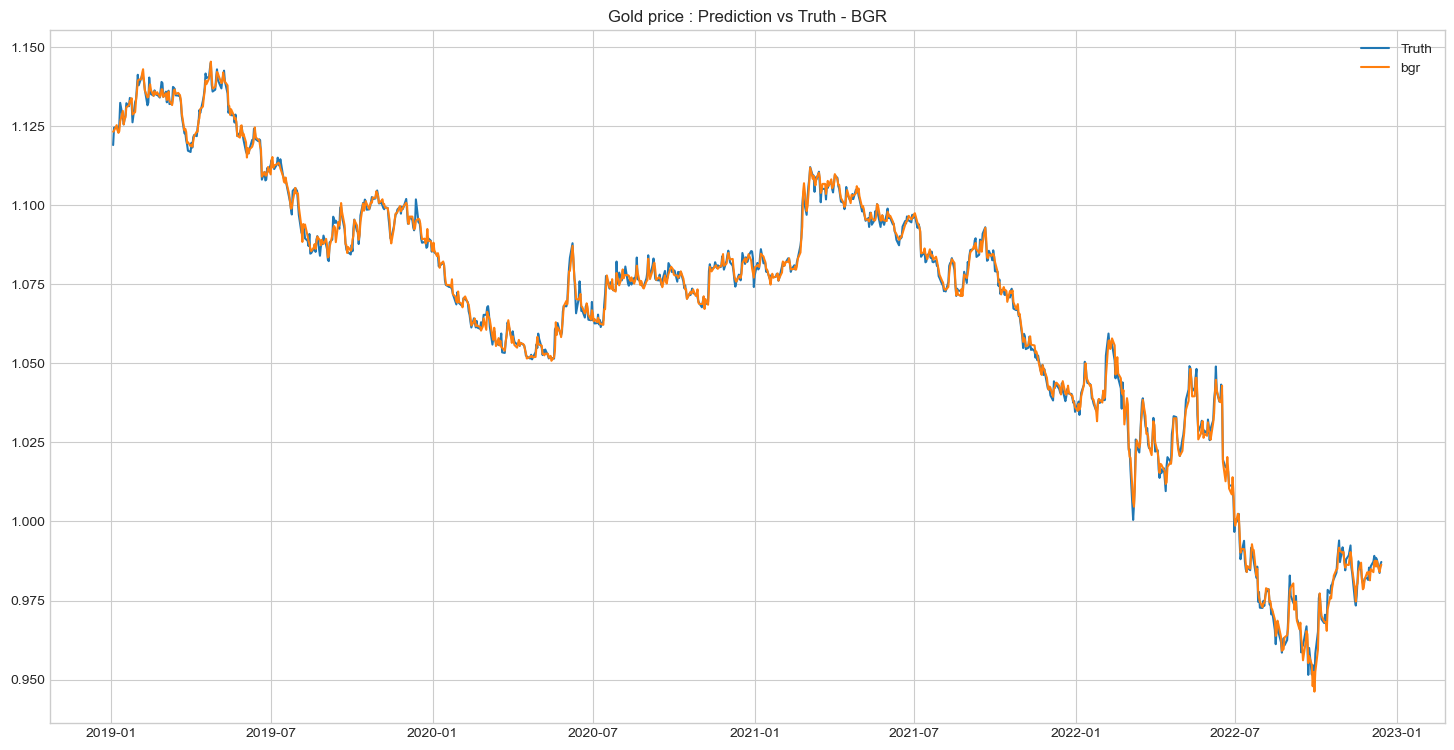

In [324]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_bgr, = plt.plot(dates, predictions_bgr)
plt.legend([plot_truth, plot_bgr], ['Truth', 'bgr'])
plt.title('Gold price : Prediction vs Truth - BGR')
plt.show()

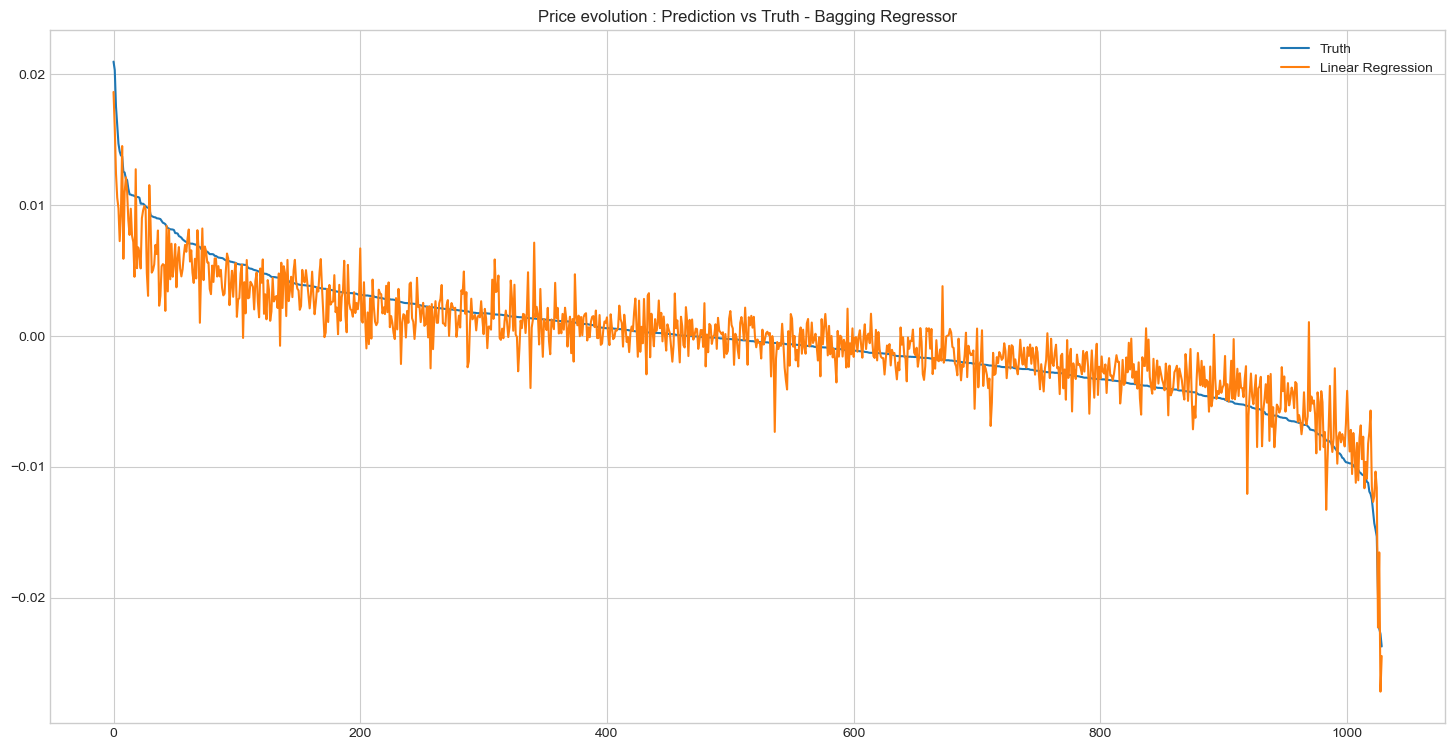

In [325]:
show_evolution(predictions_bgr, 'Bagging Regressor')

In [326]:
test_predictions_bgr = bgr.predict(X_scaled_test)

### Random Forest Regressor (RF)

In [327]:
param_grid = {
    "max_depth": [30, 50],
    "min_samples_split": [5, 10, 20],

}

rf = RandomForestRegressor(n_estimators=100)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
# print(grid_search.best_score_)

rf_best = grid_search.best_estimator_
predictions_rf = rf_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_rf)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_rf)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_rf)))


{'max_depth': 50, 'min_samples_split': 10}
RMSE: 0.013
MAE: 0.007
R^2: 0.911


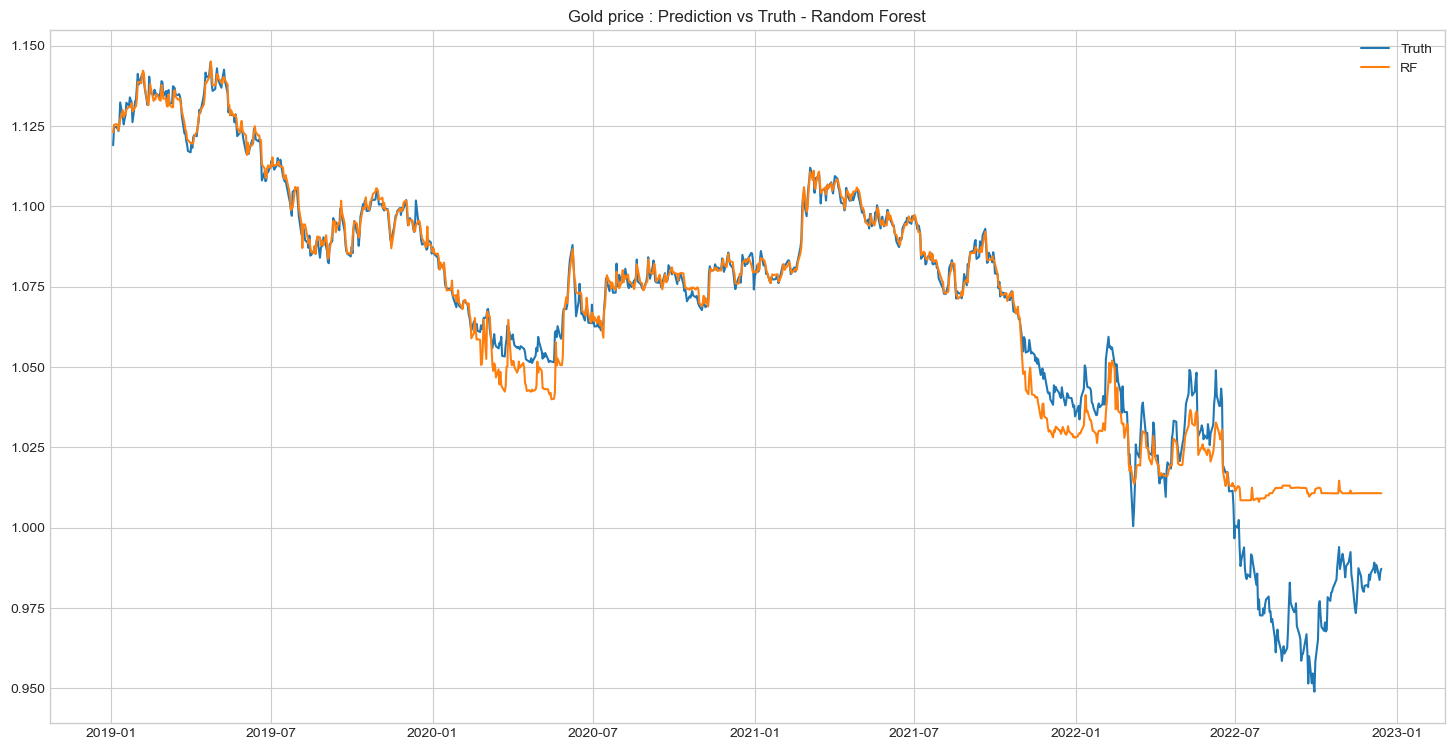

In [328]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_rf, = plt.plot(dates, predictions_rf)
plt.legend([plot_truth, plot_rf], ['Truth', 'RF'])
plt.title('Gold price : Prediction vs Truth - Random Forest')
plt.show()

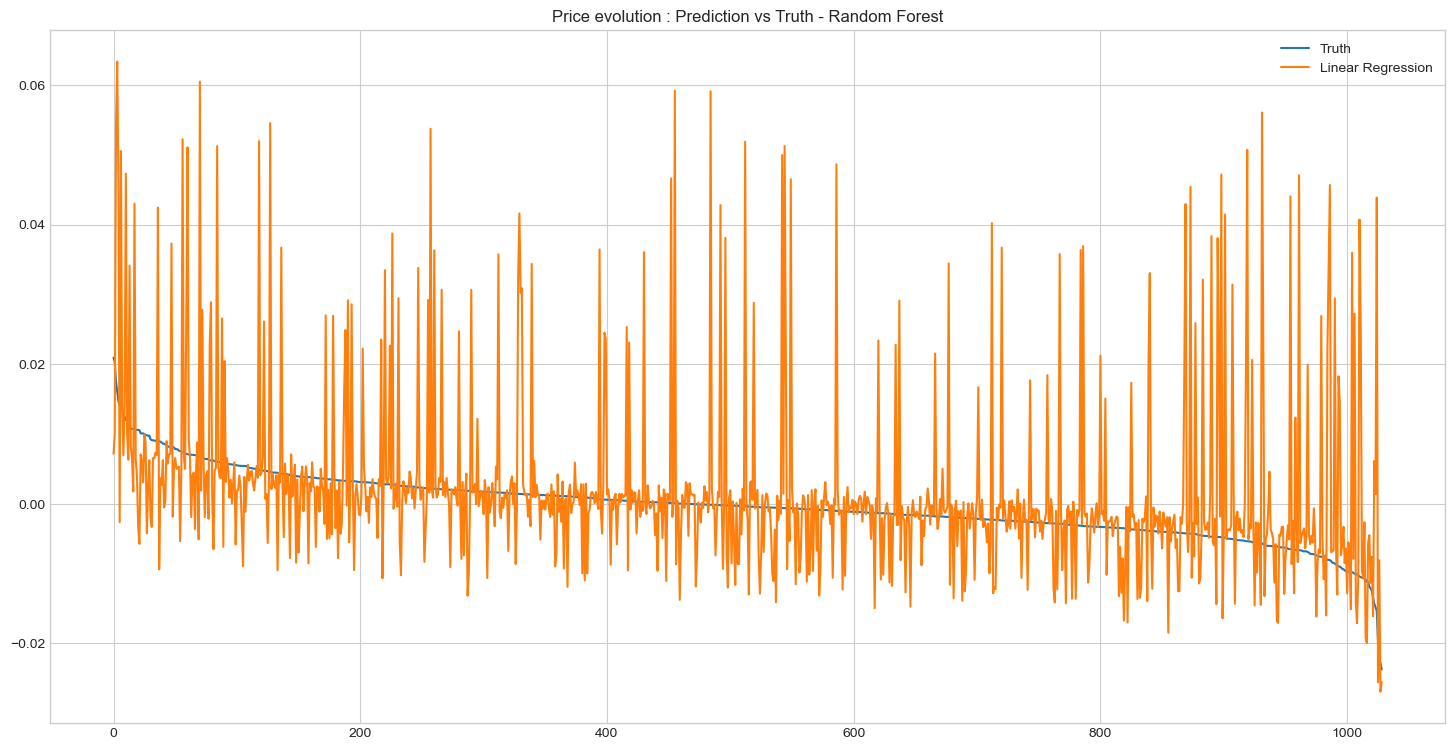

In [329]:
show_evolution(predictions_rf, 'Random Forest')

The model with the least mean_absolute_error:
 BGR    0.001412
dtype: float64


LIN    0.001522
SGD    0.002329
XGB    0.004060
BGR    0.001412
RFR    0.006753
dtype: float64

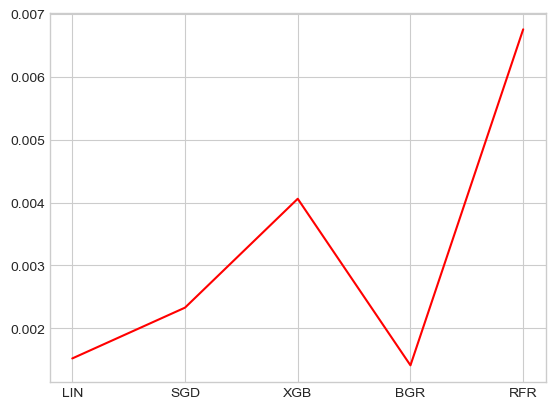

In [330]:
mae_scoring = pd.Series({'LIN':mean_absolute_error(y_test, predictions_lin),
                'SGD':mean_absolute_error(y_test, predictions_sgd),
                'XGB':mean_absolute_error(y_test, predictions_xgb),
                #'VTR':mean_absolute_error(y_test, predictions_vtr),
                'BGR':mean_absolute_error(y_test, predictions_bgr),
                'RFR':mean_absolute_error(y_test, predictions_rf)})

#filtering the regressor with the least mean_absolute_error value
filter = mae_scoring.min()
mae_min = mae_scoring[mae_scoring == mae_scoring.min()]
print('The model with the least mean_absolute_error:\n',mae_min)

plt.plot(mae_scoring, 'r')
mae_scoring

### Saving, Loading and Predicting with the BGR Model

In [331]:
#saving the BGR model with sklearn:joblib
joblib.dump(bgr, 'bgr_eurusd_10062019.pkl')

['bgr_eurusd_10062019.pkl']

In [332]:
#loading the saved model
model = joblib.load('bgr_eurusd_10062019.pkl')

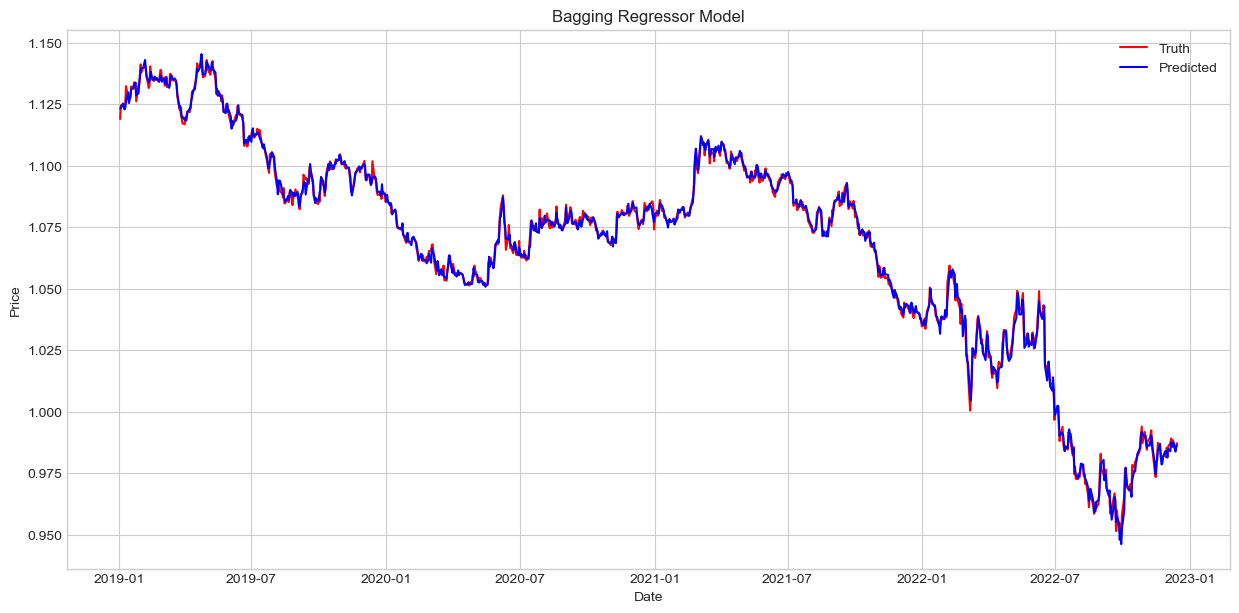

In [333]:
#Visualizing the predictions and truth values
pred = model.predict(X_scaled_test)
plt.figure(figsize=(15,7))
plt.plot(y_test, 'r', label='Truth')
plt.plot(y_test.index, pred, 'b', label='Predicted')
plt.title("Bagging Regressor Model")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

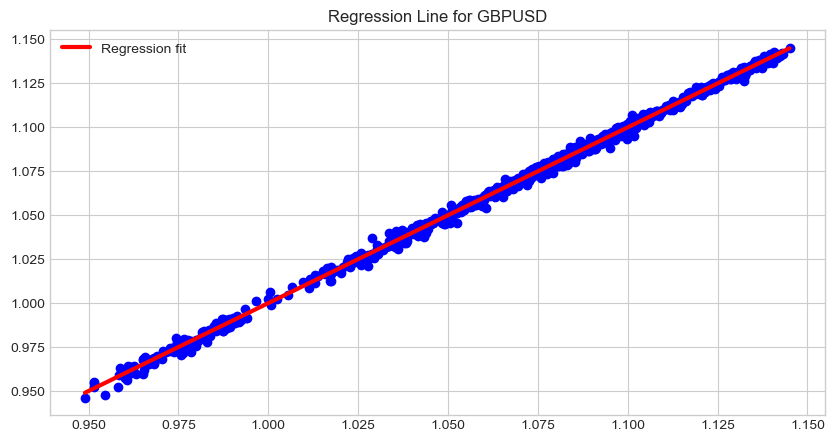

In [334]:
#plotting regression line
plt.style.use('seaborn-whitegrid')
plt.scatter(y_test, pred,color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=3, label='Regression fit')
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.title("Regression Line for GBPUSD")
plt.legend()
plt.show()

In [51]:
import yfinance as yf
def test_with_new_values (fin):
    # Récupération des données
    df_ttest = yf.download('EURCHF=X', start='2018-01-01', end='2021-12-'+ str(fin))
    # Triage des données
    df_ttest = df_ttest.drop('Volume', axis=1)
    df_ttest = df_ttest.drop('Adj Close', axis=1)
    df_ttest.columns = map(str.lower, df_ttest.columns)
    
    # Exclusion de la solution avant tout traitement
    y_a_predict = df_ttest.iloc[-1, df_ttest.columns.get_loc('close')] 
    df_ttest.iloc[-1, df_ttest.columns.get_loc('close')] = 0
        

    # Génération des Features
    data_ttest = generate_features(df_ttest)
    
    # Split des données
    X_ttest = data_ttest.drop('close', axis='columns')
    y_ttest = data_ttest.close
    
    # Normalisation
    X_scaled_ttest = scaler.transform(X_ttest)
    # Prédiction
    predictions_lin_test = lin.predict([X_scaled_ttest[-1]])
    
    # Retourne l'évolution par rapport au jour précédent
    return [y_a_predict - y_ttest[-2], predictions_lin_test[-1] - y_ttest[-2]]

df = pd.DataFrame()
for i in range(30):
    df = df.append([test_with_new_values(i+1)])
df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,0,1
0,-0.00166,-0.000724
0,-0.00036,-0.000344
0,0.00031,0.000892
0,-0.00220,0.000214
0,-0.00220,0.000214
0,-0.00220,0.000214
0,-0.00161,-0.000278
0,0.00606,0.003157
0,-0.00210,-0.001482
0,0.00161,0.001167


In [53]:
    # Récupération des données
    df_yf = yf.download('EURCHF=X', start='2018-01-01', end='2023-01-03')
    
      # Triage des données
    df_yf = df_yf.drop('Volume', axis=1)
    df_yf = df_yf.drop('Adj Close', axis=1)
    df_yf.columns = map(str.lower, df_yf.columns) # renommer les colonnes

    # Exclusion de la solution avant tout traitement
    y_a_predict = df_yf.iloc[-1, df_yf.columns.get_loc('close')] 
    df_yf.iloc[-1, df_yf.columns.get_loc('close')] = 0
    print(df_yf.close.tail(1).values)
    
    # Génération des Features
    df_features = generate_features(df_yf)
    
    # Split des données
    X_test = df_features.drop('close', axis='columns')
    y_test = df_features.close
    
    # Normalisation
    X_scaled_test = scaler.transform(X_test)

    # Prédiction
    predictions_lin_test = lin.predict([X_scaled_test[-1]])
    
    # Retourne l'évolution par rapport au jour précédent
    print(round(y_a_predict - y_test[-2], 5), round(predictions_lin_test[-1] - y_test[-2], 5))
    print(y_a_predict, predictions_lin_test[-1])

[*********************100%***********************]  1 of 1 completed
[0.]
0.004 0.00106
0.9879000186920166 0.9849625540819029
